In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (6,5)
AGENTS = ["B1","B2","B3","B4",
          "C1","C2","C3","C4",
          "D1","D2","D3","D4",
          "E1","E2","E3","E4"]   # any 16-agent ordering you used


In [51]:
path = "ckpt/block_normal/Ours_Attention/400_attn_per_episode.npy"
A = np.load(path)           # shape (E,16,16)
print(f"Loaded {A.shape[0]} episodes   matrix size {A.shape[1:]}")

# quick sanity-check: rows sum to 1 ?
print( np.round(A[0].sum(-1), 3) )     # should all be 1.000


Loaded 10 episodes   matrix size (16, 16)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


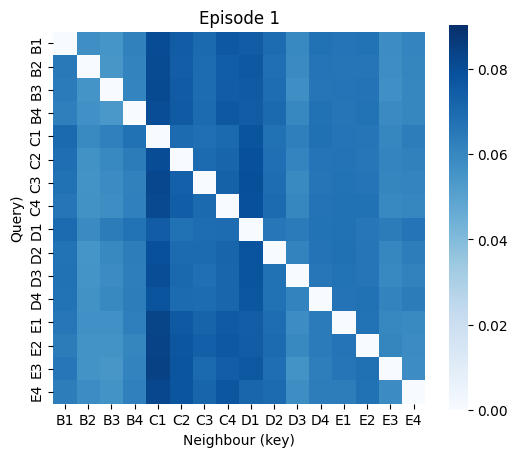

In [52]:
def show_heat(ep=0, cmap="Blues"):
    sns.heatmap(A[ep], vmax=A.max(), vmin=0,
                xticklabels=AGENTS, yticklabels=AGENTS,
                cmap=cmap, square=True, cbar=True)
    plt.title(f"Episode {ep+1}")
    plt.ylabel("Query)"); plt.xlabel("Neighbour (key)")
    plt.show()

show_heat(0)     # first episode


[[0.         0.05910396 0.05677503 0.06629185 0.08180533 0.07592937
  0.06573132 0.07734719 0.07570195 0.06830861 0.05802333 0.07096147
  0.06403245 0.06407221 0.05602955 0.05988641]
 [0.06821945 0.         0.05587923 0.06490256 0.08197369 0.07490066
  0.06489748 0.07586135 0.07682735 0.06730984 0.05678656 0.0699293
  0.06433348 0.06333073 0.05516643 0.05968188]
 [0.0684208  0.05831596 0.         0.06490043 0.08315241 0.07589822
  0.06431992 0.07630517 0.07645784 0.06753273 0.05554687 0.06962602
  0.0638294  0.06304441 0.05421934 0.05843053]
 [0.0669944  0.05829793 0.05578317 0.         0.08156438 0.07630579
  0.06602293 0.07690583 0.07689099 0.06888256 0.05848114 0.07059287
  0.06373781 0.06402264 0.05606996 0.05944763]
 [0.07309522 0.06156142 0.06262778 0.0687017  0.         0.0715191
  0.06615039 0.07201739 0.077343   0.0661908  0.05959696 0.07016011
  0.06640532 0.06415461 0.05828737 0.06218886]
 [0.07103659 0.05880513 0.05986344 0.0661221  0.08156107 0.
  0.06627561 0.0731075  0.0

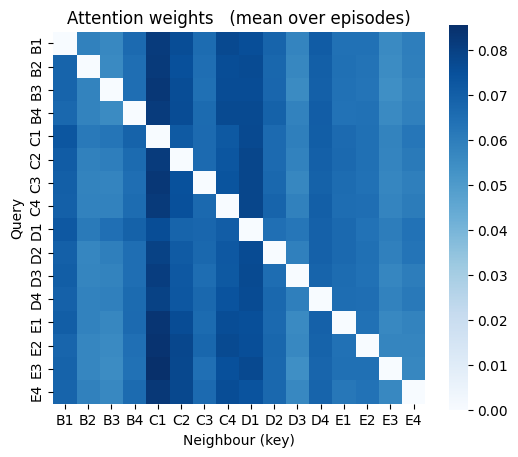

In [53]:
A_mean = A.mean(0)          # (16,16)
print(A_mean)
sns.heatmap(A_mean, vmax=A_mean.max(), vmin=0,
            xticklabels=AGENTS, yticklabels=AGENTS,
            cmap="Blues", square=True)
plt.title("Attention weights   (mean over episodes)")
plt.ylabel("Query"); plt.xlabel("Neighbour (key)")
plt.show()


In [54]:
k = 3
rows = []
for i,recv in enumerate(AGENTS):
    idx = np.argsort(A_mean[i])[::-1][:k]
    rows.append({"Agent":recv,
                 "Top-k": ", ".join([AGENTS[j] for j in idx]),
                 "Weights": ", ".join([f"{A_mean[i,j]:.2f}" for j in idx])})
pd.DataFrame(rows)


,Agent,Top-k,Weights
0,B1,"C1, C4, C2","0.08, 0.08, 0.08"
1,B2,"C1, D1, C4","0.08, 0.08, 0.08"
2,B3,"C1, D1, C4","0.08, 0.08, 0.08"
3,B4,"C1, C4, D1","0.08, 0.08, 0.08"
4,C1,"D1, B1, C4","0.08, 0.07, 0.07"
5,C2,"C1, D1, C4","0.08, 0.08, 0.07"
6,C3,"C1, D1, C2","0.08, 0.08, 0.07"
7,C4,"C1, D1, C2","0.08, 0.08, 0.07"
8,D1,"C1, B1, C4","0.08, 0.07, 0.07"
9,D2,"C1, D1, C4","0.08, 0.08, 0.07"


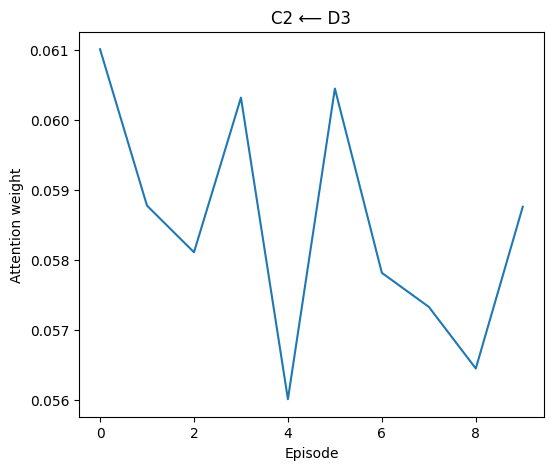

In [55]:
pair = ("C2","D3")        # receiver, neighbour
i, j = AGENTS.index(pair[0]), AGENTS.index(pair[1])

plt.plot(A[:, i, j])
plt.xlabel("Episode"); plt.ylabel("Attention weight")
plt.title(f"{pair[0]} ⟵ {pair[1]}")
plt.show()


In [56]:
def grid_heat(Amean, idx, ax=None, cmap="Blues"):
    """
    Amean : ndarray (16,16)
    idx   : int                
    """

    if ax is None:
        ax = plt.gca()

    # 1-D → 4×4 (column-major) → transpose → flip rows
    mat = Amean[idx].reshape(4, 4).T[::-1]      #   ←★ ONLY 1-LINE CHANGE

    sns.heatmap(mat,
                annot=True, fmt=".02f",
                cmap=cmap, square=True, cbar=False,
                xticklabels=["0","1","2","3"],
                yticklabels=["0","1","2","3"][::-1],
                ax=ax)
    ax.set_title(f"Agent {AGENTS[idx]}")
    ax.set_xlabel("col →")
    ax.set_ylabel("row ↑")



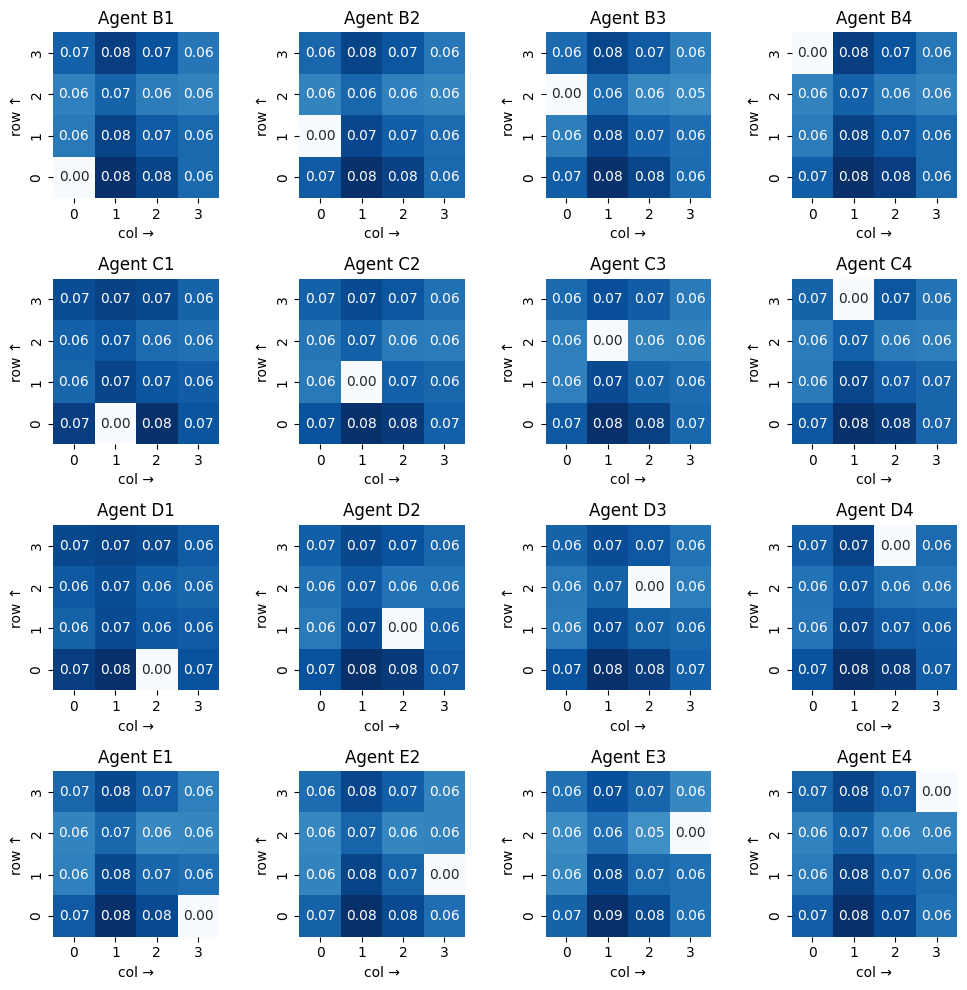

In [57]:
fig,axes = plt.subplots(4,4,figsize=(10,10))
for k,ax in enumerate(axes.ravel()):
    grid_heat(A_mean, k, ax=ax)
plt.tight_layout(); plt.show()
